### Sending a request to the torchserve encoder service

In [1]:
import httpx
import base64
from PIL import Image
from PIL.ImageOps import equalize, autocontrast
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import json
#encode_url="http://127.0.0.1:7080/predictions/sam_vit_h_encode" # make sure to select correct port. 70* for cpu, 80* for gpu after starting both serving containers locally
encode_url="http://127.0.0.1:8080/predictions/sam_vit_h_encode" 
#encode_url = "https://sas-gpu.ds.io/predictions/sam_vit_h_encode"
pth_fox = "../data/sample-img-fox.jpg"
input_point_fox = (150, 75)

pth_slick = "../data/tile_with_slick_512_512.png"
input_point_not_on_slick = (10, 120)
input_point_on_slick = (6, 120)
input_label = 1

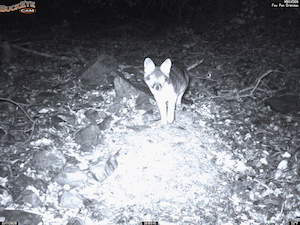

In [2]:
img_fox = Image.open(pth_fox)
img_fox

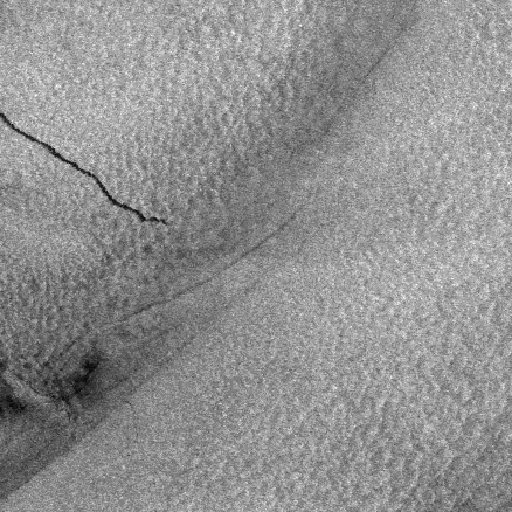

In [3]:
img_slick = Image.open(pth_slick)
autocontrast(img_slick, cutoff=0, ignore=None, mask=None, preserve_tone=False)

In [4]:
# reads image as bytes, converts bytes to string so it can be sent as a post request
with open(pth_slick, 'rb') as f:
    byte_string = f.read()
    base64_string = base64.b64encode(byte_string).decode('utf-8')

payload = {"encoded_image": base64_string}

### Time to encode image on 1080 Ti GPU

In [5]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError) as e:
    print("wait and try again")

CPU times: user 21 ms, sys: 4.4 ms, total: 25.4 ms
Wall time: 2.62 s


In [6]:
response.content

b'{\n  "status": "success",\n  "image_embedding": "Ig4IvkC8NL6E1i++jLEqvnVdI77AwCq+06crvhijIL4PAyi+7Y0gvin2K74LpRW+6WQQvumrN75YsBi+9oQjvsZJJ75YECG+IM0ZvsfxG76ehim+iUgbvm5KCL7Tqyi+k4EfvpQ4C76T1w++5rIXvs7f572+SgW+njvgvYZ1/72iVP+9HGL8vQqe471u3629/uXWvf4smb38ueK95DzLvdKP1b1E1Mi9Zii0vYsbWL0RDUi9LmyIvQJRgL2xL1i9L7JTvQoXDr03wiS9QGiCvazD1r1AVve9JSkAvpR6zr1CXvi92gTSvcjQrL38j+W9oAzNvTB32b2iIuS9+1l3vcjvN76royy+s/0gvkpHH76Ocxu+AJMSvphjFr7Mkxu+DjgIvlIMB76GG/+9Zk/dveVhFb4QwCu+pO0bvix2Cr6nvga+ln4Fvtr6CL4wzvW9UmD9vcbf6r1gh829FG3jvWy6sr0Qt7S9+Jnjvb7b2L0qAqS90uOqvdKJn73ab7q9WF+kvfDKjr0H4mG9Bo2AvdBZNL1Xnku98ZVzvTOySL2cFJS91ZNlvWAuNb3U4hO9EnKMvMqlV7woo4+7lASiuyGxtDx2p/k7CtO4vMxMjb0maia+JRcpvuo+F76V9By+Ix0IvtCdzb0ydJq9tg/Ivfo7tL2uRae9MGq2vbpdvb0/c1i+dP1Jvvd/Qb49yDu+lAA9vmDfKL5QNSS+VOQpvgrxIL5fTCW+Tt8gvuN8GL7NSBe+DndPvtUAPL4FRyi+Z20jvjThG77cKxm+eGQOvr/QEL4dpxK+TqXsvSZ1+r0ctOS9efIBvjlcEb4eDQO+hqPzvV6q3r2uZu29uK3uvW5Rxb2Ocbq9/F6HvSSKib1jqmq9vAjBve9Oer1XyGG9lKaUvaDpg70kuaS9HAk+vbU5Cb2G5Cy9mCiMvMD2UDyuNFu8vM4nO

In [7]:
response

<Response [200 ]>

### Image embeddings for the image above

In [8]:
encoded_embedding_string = response.json()['image_embedding']
base64_bytes = base64.b64decode(encoded_embedding_string)
image_embedding = np.frombuffer(base64_bytes, dtype=np.float32)
image_embedding

array([-0.13286641, -0.17649937, -0.17171675, ..., -0.1328539 ,
       -0.1372815 , -0.1409665 ], dtype=float32)

### Sending the image embeddings to the decoder service

In [9]:
img_shape = np.array(img_slick).shape
decode_payload = {
    "image_embeddings": encoded_embedding_string,
    "image_shape": img_shape,
    "input_label": input_label,
    "input_point": input_point_on_slick
}

In [10]:
%%time
decode_url="http://127.0.0.1:7080/predictions/sam_vit_h_decode" # make sure to select correct port. 70* for cpu, 80* for gpu
#decode_url="https://sas.ds.io/predictions/sam_vit_h_decode"
response = httpx.post(decode_url, json=decode_payload, timeout=None)

CPU times: user 33.3 ms, sys: 6.8 ms, total: 40.1 ms
Wall time: 351 ms


In [11]:
response

<Response [200 ]>

In [12]:
encoded_masks_string = response.json()['masks']
base64_bytes_masks = base64.b64decode(encoded_masks_string)
masks = np.frombuffer(base64_bytes_masks, dtype=np.float32)

#### We reshape the masks to the original image shape, adding a channel for the alpha channel, so it is 4 instead of 3

In [13]:
masks = masks.reshape((1, 4, 512, 512))
masks = masks > .5

### With our encoder and decoder service, we get a solid mask prediction by just supplying a point on the object of interest!

In [14]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

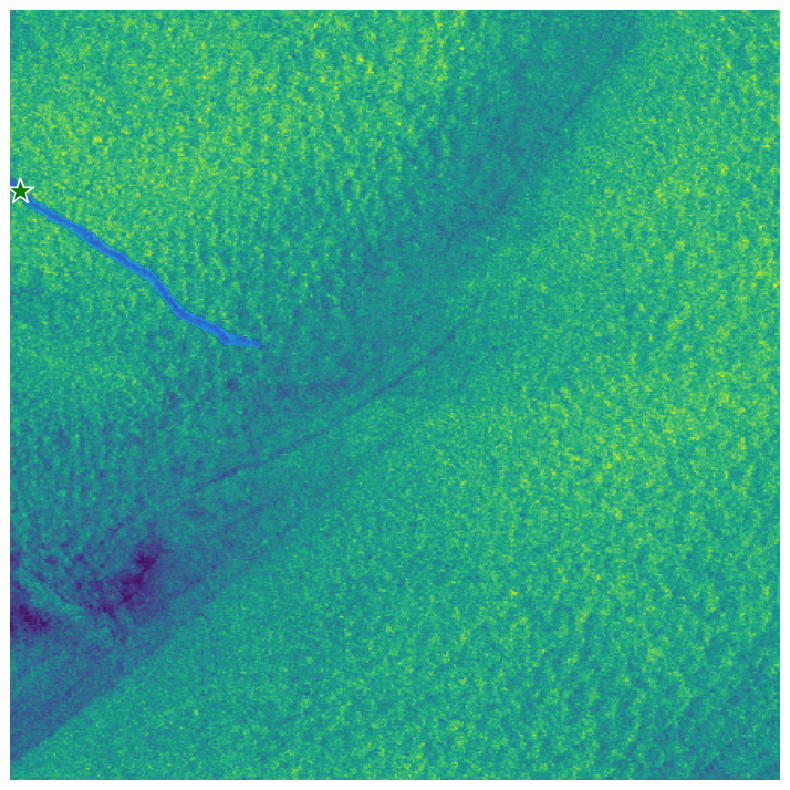

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(img_slick))
show_mask(masks[:,0,:,:], plt.gca())
input_point_arr = np.array(input_point_on_slick)[np.newaxis,:]
input_label_arr = np.array(input_label)[np.newaxis]
show_points(input_point_arr, input_label_arr, plt.gca())
plt.axis('off')
plt.show() 

### Running the Geospatial endpoint that returns geojson

In [2]:
import json
with open("../data/requestProps_.json") as f:
    r = json.load(f)

{'canvas': '',
 'masks': {},
 'image_embedding': {},
 'requestProps': {'image_shape': [818, 423],
  'input_label': 1,
  'input_point': [466, 218],
  'map_crs': 'EPSG:3857',
  'map_extent': [482923.97110453265,
   6595850.722898556,
   484386.62184437277,
   6596607.081410723],
  'map_clic_coords': [[466, 218],
   [543, 78],
   [383, 362],
   [440, 266],
   [504, 147]]}}
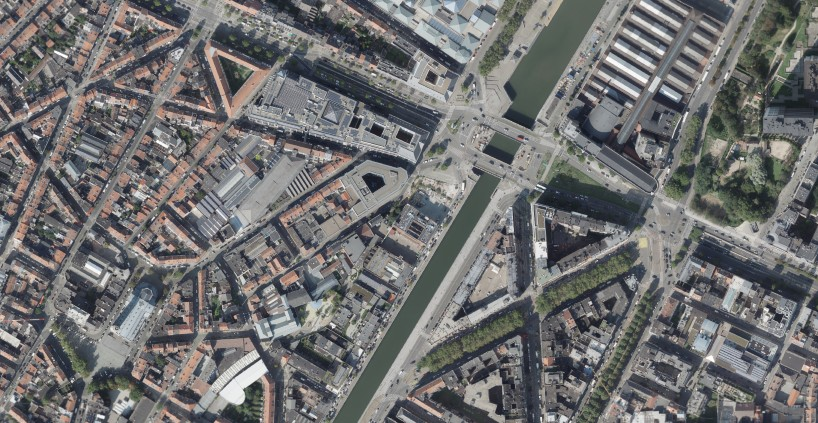

In [3]:
r

In [7]:
import rasterio

with rasterio.open("../data/sample-georeferenced_burn_scar.tif") as dataset:
    src = dataset.read()
    bbox = dataset.bounds
    crs = dataset.crs
    

In [8]:
bbox

BoundingBox(left=593640.0, bottom=4331790.0, right=609000.0, top=4347150.0)

In [38]:
r['image_embedding'].keys()

dict_keys(['status', 'image_embedding'])

In [ ]:
import numpy as np
import requests
import base64
import json
import rasterio

# reads image as bytes, converts bytes to string so it can be sent as a post request
pth_geo = "../data/sample-georeferenced_burn_scar.tif"
with open(pth_geo, 'rb') as f:
    byte_string = f.read()
    base64_string_geo = base64.b64encode(byte_string).decode('utf-8')

payload = {"encoded_image": base64_string}
